In [1]:
import numpy as np
import pandas as pd
import nltk
import pandas as pd
import re

In [2]:
events = pd.read_csv("LTD_rawevents.csv")
pd.set_option('display.max_columns',200)

In [4]:
events_working = events[["STATE", "CITY", "US REGION", "MONTH", "DATES", "EVENT NAME", "EVENT TYPE",\
                        "WHAT TO DO?", "EVENT DESC (1 SC)", "GOOD 4 KIDS?", "ADMISSION (FREE/FEE)", "FEE DETAIL"]]
events_working

,STATE,CITY,US REGION,MONTH,DATES,EVENT NAME,EVENT TYPE,WHAT TO DO?,EVENT DESC (1 SC),GOOD 4 KIDS?,ADMISSION (FREE/FEE),FEE DETAIL
0,Illinois,Chicago,Midwest,Oct,Early Oct,Bacon and Beer Classic,NaN,"TASTEBUDS, A&E",Prepare yourself for 100+ draft beers from reg...,NO,FEE,Tickets coming soon!
1,Illinois,Chicago,Midwest,Apr,Late Apr,Cotopaxi Questival,NaN,ACTIVE,The Cotopaxi Questival is a 24-hour adventure ...,YES,FEE,NOT IN 2019
2,Illinois,Schaumburg,Midwest,Jun,Early Jun,Gluten Free and Allergen Friendly Expo,Food Expo,"TASTEBUDS, LEARN",Premier gluten and allergen-free consumer show...,YES,FEE,$15 Adult Day Pass. $25 Adult Weekend Pass (ba...
3,Indiana,Indianapolis,Midwest,May,Mid/Late May,Bacon and Beer Classic,NaN,"TASTEBUDS, A&E",We bring together the best local breweries and...,NO,FEE,Not in 2019.
4,Michigan,Kalamazoo,Midwest,Aug,Late Aug,Bikes and Beers Kalamazoo,NaN,"ACTIVE, A&E",Featuring 15 and 30-mile rides departing from ...,NO,YES,$25 event general (spectator). $40-$50 registr...
...,...,...,...,...,...,...,...,...,...,...,...,...
1926,Arkansas,Little Rock,South,Mar,Mid Mar,The Fulcrum Festival,Music Festival,A&E,NaN,NaN,NaN,NaN
1927,Florida,Coral Gables,South,Nov - Jan,Late Nov - Early Jan,The NightGarden – A Magical Light Spectacular,NaN,A&E,Journey inside Miami's most gorgeous garden at...,YES,FEE,$28 event general (general admission + discoun...
1928,Florida,Fort Lauderdale,South,Jan,Mid Jan,The Yoga Expo Florida,NaN,ACTIVE,This 2-day event brings together the local yog...,YES,FEE,$35 event general (all day admission + early b...
1929,Florida,West Palm Beach,South,Feb,Early Feb,Urban Yoga Fest and the Bohemian Collective,NaN,ACTIVE,An inspiring three day festival of like-minded...,YES,FEE,$20-$25 event general. $60 event premium (3 da...


In [5]:
events_working = events_working.dropna(subset = ["EVENT DESC (1 SC)"])
events_working = events_working.dropna(subset = ["WHAT TO DO?"])
events_working["Alex_targets"] = events_working["WHAT TO DO?"]
events_working['Desc_with_name'] = events_working[['EVENT NAME', 'EVENT DESC (1 SC)']].apply(lambda x: ' '.join(x), axis=1)
events_working = events_working.drop(["EVENT DESC (1 SC)", "WHAT TO DO?"], axis = 1)
events_working = events_working.reset_index().drop("index", axis = 1)

In [6]:
# Preprocessing of text data

# Convert all the string to lower cases
events_working.Desc_with_name = events_working.Desc_with_name.str.lower()

# \S+ means anything that is not an empty space
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: re.sub('http\S*', '', x))

# \s+ means all empty space (\n, \r, \t)
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: re.sub('\s+', ' ', x))
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: re.sub('[^\w\s]', '', x))

In [8]:
# Ignoring words that are too common to be deterministic, adding domain words

from nltk.corpus import stopwords
stop = stopwords.words('english') + ["festival", "event", "festiv", "day", "week", "month", "year", "much"\
                                    "feature", "celebration", "celebrate", "featuring", "featurin", "include", \
                                    "weekend", "event", "featuring", "enjoy", "fest", "cotopaxi", "questival", \
                                    "around", "best", "including", "great", "first", "come", "throughout", "area", \
                                    "festivals", "events", "fairs", "days", "celebrations", "fests", "includes", \
                                    "features", "celebrating", "areas"]

events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda text: " ".join(word for word in text.split() if word not in stop))

In [9]:
# Tokenizes description into list of words

from nltk.tokenize import word_tokenize 

events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: word_tokenize(x))

In [10]:
# Lemmatizes words (ignores pluralization, tenses, etc)

from nltk import WordNetLemmatizer

lemztr = WordNetLemmatizer()
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: ' '.join([lemztr.lemmatize(word) for word in x]))

In [11]:
from textblob import TextBlob
import itertools

In [12]:
# The following cells create helper functions for describing word frequency rates in the corpus of event descriptions

def frame_to_dict (x): 
    all_list = list(x)
    all_dict = {}
    for thing in all_list:
        all_dict[thing] = all_list.count(thing)
    return all_dict

def n_gram_flattener(L): 
    N = []
    for item in L:
        new = "_".join(item)
        N.append(new)
    return N

In [13]:
# Prints amount of unique tokens in the dictionary, and how many times each word appears in corpus

blob = ' '.join(events_working.Desc_with_name)
len(blob)

new_blob = TextBlob(blob).ngrams(1)
new_blob_list = list(new_blob)
unigrams_for_dict = n_gram_flattener(new_blob_list)
new_blob_dict = frame_to_dict(unigrams_for_dict)
print(len(list(new_blob_dict.keys())))
{k: v for k, v in sorted(new_blob_dict.items(), key=lambda item: item[1], reverse = True)}

6634


{'music': 614,
 'food': 559,
 'art': 443,
 'live': 361,
 'craft': 357,
 'beer': 299,
 'show': 249,
 'local': 230,
 'wine': 229,
 'film': 226,
 'activity': 226,
 'vendor': 222,
 'entertainment': 216,
 'fun': 209,
 'family': 201,
 'world': 191,
 'community': 177,
 'new': 164,
 'ride': 163,
 'free': 155,
 'book': 145,
 'dance': 144,
 'yoga': 142,
 'game': 136,
 'experience': 133,
 'race': 132,
 'performance': 126,
 'fair': 125,
 'kid': 122,
 'contest': 120,
 'much': 120,
 'balloon': 120,
 'international': 119,
 'artist': 119,
 'workshop': 118,
 'one': 118,
 'country': 112,
 'winter': 111,
 'culture': 111,
 'parade': 108,
 'annual': 107,
 'city': 100,
 'carnival': 99,
 'largest': 97,
 'american': 94,
 'tasting': 93,
 'join': 93,
 'stage': 92,
 'demonstration': 91,
 'competition': 91,
 'park': 88,
 'class': 87,
 'run': 86,
 'people': 85,
 'variety': 83,
 'also': 83,
 'river': 83,
 'street': 82,
 'bacon': 81,
 'fall': 81,
 'u': 81,
 'hot': 81,
 'showcase': 80,
 'get': 78,
 'state': 78,
 'nat

In [14]:
# 

def word_in_event(word):
    T = []
    F = []
    for i in range(len(events_working.Desc_with_name)): 
        if word in events_working.Desc_with_name[i]: 
            T.append(word in events_working.Desc_with_name[i])
        else:
            F.append(word in events_working.Desc_with_name[i])
    print(f"The word \"{word}\" appears in {round((len(T) / len(events_working.Desc_with_name)) * 100, 1)} % of events.")

In [15]:
# Prints the words that occur more than 300 times overall, and shows the percentage of events they appear in

for word in new_blob_dict.keys():
    if new_blob_dict[word] > 300:
        print(word_in_event(word))

The word "music" appears in 31.3 % of events.
None
The word "craft" appears in 18.9 % of events.
None
The word "food" appears in 29.3 % of events.
None
The word "art" appears in 33.8 % of events.
None
The word "live" appears in 20.2 % of events.
None


In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

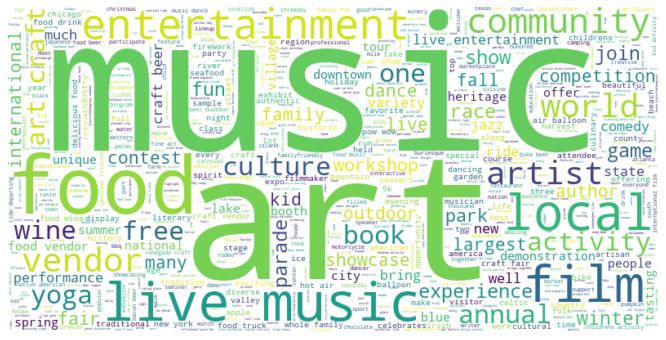

In [17]:
# Generates word cloud of all words in event corpus

wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)

wc.generate(' '.join(events_working.Desc_with_name))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Count Representations of Words

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# Creates column that only includes first event label in list when multiple are present

events_working.Alex_targets_top = events_working.Alex_targets.apply(lambda x: x.split(',')[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# Processing event descriptions with Count Vectorizer/Bag of words method 

# Includes 1 and 2 word terms, words that appear 7 or more times but in less than 90% of events
count_vec4 = CountVectorizer(ngram_range=(1,2), min_df=7, max_df=.9, max_features=5000)
X_train_count4 = count_vec4.fit_transform(events_working['Desc_with_name'])
X_train_count4.shape

(1814, 1517)

In [38]:
# Running Naive Bayes classifier on bag of words, training on all events but the first 20

multiNB = MultinomialNB()
cntvecMNB = multiNB.fit(X_train_count4[20:,], events_working.Alex_targets_top[20:])

# Testing NB classifier on first 20 events, viewing the predicted label output

new_docs = X_train_count4[:20]
cnt_predicted = cntvecMNB.predict(new_docs)
cnt_predicted

array(['TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'TASTEBUDS', 'ACTIVE',
       'TASTEBUDS', 'TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'ACTIVE', 'LEARN',
       'ACTIVE', 'ACTIVE', 'LEARN', 'TASTEBUDS', 'TASTEBUDS', 'ACTIVE',
       'A&E', 'A&E', 'ACTIVE'], dtype='<U9')

In [39]:
# The actual labels Alex assigned for the first 20 events, for comparison

events_working.Alex_targets_top[:20]

0     TASTEBUDS
1        ACTIVE
2     TASTEBUDS
3     TASTEBUDS
4        ACTIVE
5     TASTEBUDS
6     TASTEBUDS
7        ACTIVE
8     TASTEBUDS
9        ACTIVE
10        LEARN
11       ACTIVE
12          A&E
13        LEARN
14    TASTEBUDS
15          A&E
16          A&E
17          A&E
18          A&E
19       ACTIVE
Name: Alex_targets, dtype: object

In [40]:
# Alternative word processing method to plain count vectorizer: TfIdf (penalizing frequent words)

tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=7, max_df=.9, max_features=5000) 
X_train_tf = tf_idf.fit_transform(events_working['Desc_with_name'])

In [41]:
# Fitting NB classifier on new TfIdf word data

tf_idfMNB = multiNB.fit(X_train_tf[20:], events_working.Alex_targets_top[20:])

# Showing predictions for first 20 events

new_docs_tf = X_train_tf[:20]
tfidf_predicted = tf_idfMNB.predict(new_docs_tf)
tfidf_predicted

array(['TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'TASTEBUDS', 'ACTIVE',
       'TASTEBUDS', 'TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'ACTIVE', 'LEARN',
       'ACTIVE', 'ACTIVE', 'LEARN', 'TASTEBUDS', 'A&E', 'ACTIVE', 'A&E',
       'A&E', 'ACTIVE'], dtype='<U9')

In [42]:
# Printing metric reports for both word count methods
from sklearn import metrics
print('The report for CountVectorizer word embedding through a Multinomial model:')
print(metrics.classification_report(events_working.Alex_targets_top[:20], cnt_predicted, target_names=events_working.Alex_targets_top.unique() ))

The report for CountVectorizer word embedding through a Multinomial model:
              precision    recall  f1-score   support

   TASTEBUDS       1.00      0.40      0.57         5
      ACTIVE       0.75      1.00      0.86         6
       LEARN       1.00      1.00      1.00         2
         A&E       0.88      1.00      0.93         7

    accuracy                           0.85        20
   macro avg       0.91      0.85      0.84        20
weighted avg       0.88      0.85      0.83        20



In [44]:
print('The report for TF-IDF Vectorizer word embedding through a Multinomial model:')
print(metrics.classification_report(events_working.Alex_targets_top[:20], tfidf_predicted, target_names= events_working.Alex_targets_top.unique()))

The report for TF-IDF Vectorizer word embedding through a Multinomial model:
              precision    recall  f1-score   support

   TASTEBUDS       1.00      0.60      0.75         5
      ACTIVE       0.75      1.00      0.86         6
       LEARN       1.00      1.00      1.00         2
         A&E       1.00      1.00      1.00         7

    accuracy                           0.90        20
   macro avg       0.94      0.90      0.90        20
weighted avg       0.93      0.90      0.89        20



## LDA (Latent Dirichlet Allocation)

In [45]:
import gensim

In [46]:
# Processes all but the first event so we can test its categorization afterward

processed_docs  = []

for doc in events_working['Desc_with_name'][1:]:
    doc = doc.split()
    processed_docs.append(doc)
    
processed_docs

[['24hour',
  'adventure',
  'race',
  'team',
  '26',
  'friend',
  'explore',
  'unknown',
  'city',
  'wild',
  'space',
  'thing',
  'never',
  'thought',
  'possible',
  'share',
  'stoke',
  'fun',
  'supportive',
  'community'],
 ['gluten',
  'free',
  'allergen',
  'friendly',
  'expo',
  'premier',
  'gluten',
  'allergenfree',
  'consumer',
  'show',
  'united',
  'state'],
 ['bacon',
  'beer',
  'classic',
  'bring',
  'together',
  'local',
  'brewery',
  'restaurant',
  'stadium',
  'epic',
  'venue',
  'country',
  'ultimate',
  'craft',
  'beer',
  'foodie',
  'biggest',
  'bacon',
  'country',
  'dont',
  'miss',
  'party',
  'roll',
  'town',
  'much',
  'food',
  'beer',
  'thing',
  'life'],
 ['bike',
  'beer',
  'kalamazoo',
  '15',
  '30mile',
  'ride',
  'departing',
  'bell',
  'eccentric',
  'cafe',
  'traveling',
  'beautiful',
  'region',
  'kalamazoo',
  'mi',
  'ride',
  'feature',
  'rest',
  'stop',
  'refreshment',
  'postride'],
 ['bacon',
  'beer',
  'c

In [47]:
# Creating bag of words with indices

dictionary = gensim.corpora.Dictionary(processed_docs)

In [48]:
# Keep words that appear 7 or more times, but in less than 20% of events

dictionary.filter_extremes(no_below=7, no_above=0.2, keep_n=50000)
len(dictionary.keys())

1090

In [49]:
# Shows the first 10 dictionary entries of words in dataset

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 24hour
1 26
2 adventure
3 city
4 community
5 explore
6 friend
7 fun
8 never
9 possible
10 race


In [50]:
# Shows how many times each word appears in specified document
# example: (2,1) means word #2 in the dictionary appears once in this (0th) event

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1)]

In [55]:
from gensim import models
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis.gensim

In [57]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corpus, num_topics=6, id2word=dictionary, passes=2, eta=.01)
lda_model_tfidf.save('lda_tfidf_final.model')

In [60]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.030867  0.013230       1        1  22.554585
3      0.011230 -0.050945       2        1  18.441271
4      0.039631 -0.048837       3        1  16.371914
2      0.037850 -0.014595       4        1  14.906528
5      0.013591  0.109849       5        1  14.275867
0     -0.133169 -0.008701       6        1  13.449841, topic_info=     Category        Freq      Term       Total  loglift  logprob
174   Default  192.000000      film  192.000000  30.0000  30.0000
331   Default   96.000000   balloon   96.000000  29.0000  29.0000
1062  Default   35.000000  illusion   35.000000  28.0000  28.0000
90    Default  124.000000      book  124.000000  27.0000  27.0000
121   Default  113.000000      yoga  113.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
36     Topic6   20.480843     craft  189.569183  -0.2191  -5.2682
225    Topic6   19.178415    family  127.109314   0.1149  -5.3340
256    Topic6   18.566246     world  126.359764   0.0884  -5.3664
41     Topic6   18.779202     local  140.493988  -0.0062  -5.3550
262    Topic6   17.818745  activity  127.186188   0.0408  -5.4075

[415 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
481       1  0.672154   10k
481       2  0.096022   10k
481       6  0.192044   10k
52        1  0.066518    15
52        2  0.099778    15
...     ...       ...   ...
578       1  0.293751  york
578       2  0.106819  york
578       4  0.026705  york
578       5  0.453979  york
578       6  0.106819  york

[1376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 6, 1])

In [ ]:
# topic 1 - outdoor fairs, family / children friendly
# topic 2 - locations /"world", artsy expos, comedy, wine/craft
# topic 3 - local/ethnic culture
# topic 4 - physical and mental wellness - active, but also comedy, literacy
# topic 5 - food parties
# topic 6 - southern cultural

## 1 and 2 both have art as overlap

In [61]:
# Testing first event in dataset to see which clusters the model relates it to, and with how much confidence

unseen_document = events_working["Desc_with_name"][0].split()

bow_vector = dictionary.doc2bow(unseen_document)

for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.973810613155365	 Topic: 0.009*"balloon" + 0.008*"hot" + 0.007*"beer" + 0.007*"bacon" + 0.007*"art"


### Doc2Vec

In [62]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [63]:
# Preprocessing for Doc2Vec model

desc = events_working.Desc_with_name.str.split()
tags = events_working.Alex_targets.str.lower().str.replace(r'[^a-zA-Z ]','').str.split()
tags[:10]

0       [tastebuds, ae]
1              [active]
2    [tastebuds, learn]
3       [tastebuds, ae]
4          [active, ae]
5       [tastebuds, ae]
6       [tastebuds, ae]
7          [active, ae]
8       [tastebuds, ae]
9          [active, ae]
Name: Alex_targets, dtype: object

In [64]:
docs = [TaggedDocument(d, t) for d, t in zip(desc, tags)]

In [65]:
doc_model = Doc2Vec(docs, dbow_words = 1, vector_size=10, window=7, min_count=2, workers=4)

In [66]:
# Example of new event addition and its label associations

new_vec = doc_model.infer_vector(["Come", "on", "down", "to", "our" "fourth", "of", "july", "fireworks", "festival", \
                            "we", "have", "the", "best", "show", "in", "town", "dozens", "of", "food", "vendors", \
                            "craft", "beer", "live", "music", "and", "games", "and", "tons", "of", "family", \
                            "friendly", "fun"])
doc_model.docvecs.most_similar([new_vec])

[('tastebuds', 0.9721555709838867),
 ('ae', 0.8998920321464539),
 ('active', 0.8857884407043457),
 ('learn', 0.8407571315765381)]

In [67]:
# Pre-cluster labelling

doc_len_list = list(range(0, len(desc)))
stupid_list = []
for i in range(0, len(doc_len_list)):
    stupid_list.append(str(doc_len_list[i]).split())
#print(type(stupid_list[0]))
len(stupid_list) # amount of entries

1814

In [68]:
cluster_docs = [TaggedDocument(d,s) for d,s in zip(desc, stupid_list)]
doc_model_2 = Doc2Vec(cluster_docs, dbow_words = 1, vector_size=10, window=7, min_count=2, workers=4)

In [71]:
# Shows event entries and how similar it is to new event

doc_model_2.docvecs.most_similar([new_vec])

[('1290', 0.8347976207733154),
 ('507', 0.8268419504165649),
 ('1507', 0.8236880302429199),
 ('582', 0.7999029159545898),
 ('1754', 0.7730684280395508),
 ('1329', 0.7205994725227356),
 ('991', 0.6989998817443848),
 ('1217', 0.6972242593765259),
 ('200', 0.6936211585998535),
 ('1273', 0.6896488666534424)]

In [75]:
cluster_docs[1754]

TaggedDocument(words=['native', 'virginia', 'tech', 'spring', 'pow', 'wow', 'traditional', 'native', 'american'], tags=['1754'])